In [1]:
### imports
import pandas as pd
import ast
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys

sys.path.append("..")
sys.path.append("../src")

from src.datahandling.loading import load_data  # loading
import src.datahandling.visualization as vis  # plotting
from src.models.xgb import XGB
from src.datahandling.preprocessing import *

### load benchmarks
benchmarks = pd.read_csv("../results/benchmarks.csv")

# XG-Boost Regression

XG Boost stands for "Extreme Gradient Boosting". It is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. The algorithms comes along with a lot of hyperparameters to tune. Since this is not feasible with the hardware at hand, we will use a randomized search over the hyperparameter space.

Additionally, there were some problems with executing a model fit. We needed to downgrade the version of xgboost to 0.90. This comes along with some warnings. Consider, upgrading the version if you are able to call the fit function. Please find further informations on https://github.com/dmlc/xgboost/issues/7504 (newest one I could find).

In [2]:
model = Pipeline(
    [
        ("norm", Normalizer()),
        ("st", SupervisedTransformer(encode_time=["hour", "month"])),
        ("xgb", XGB()),
    ]
)

param_grid = {
    "st__window_size": [8],
    "st__horizon": ["10min", "hourly", "daily"],
    "xgb__learning_rate": [0.01, 0.1, 0.2],
    "xgb__n_estimators": [100, 200, 300],
    "xgb__max_depth": [3, 4, 5],
    "xgb__min_child_weight": [1, 2, 3],
}

## British Dataset - Kelmarsh

In [3]:
### loading data
TURBINE_ID = 2
data_brit = load_data(turbine_id=TURBINE_ID, which_data="British")

### cleaning  data
cleaner = DataCleaner(
    features=[
        "Power (kW)",
        "Wind speed (m/s)",
        "Wind direction (°)",
        "Rotor speed (RPM)",
    ],
    rename_features=[
        "power",
        "wind_speed",
        "wind_direction",
        "rotor_speed",
    ],
)
data_brit = cleaner.transform(data_brit)

# create train and test set (exactly as used in the benchmarks)
test_start = benchmarks["test_start"][0]
test_end = benchmarks["test_end"][0]
X_train, y_train, X_test, y_test = train_test_split(
    df=data_brit, test_start=test_start, test_end=test_end, target_var="power"
)

In [4]:
### hyperparameter tuning
### RUNTIME: ~ 45 min on my machine
do_gridsearch = False

if do_gridsearch:

    grid_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=TimeSeriesSplit(n_splits=3),
        verbose=2,
        n_jobs=-1,
        n_iter=15,
        refit=False,
    )

    grid_search.fit(X_train, y_train)
    res_gs_brit = pd.DataFrame(grid_search.cv_results_)
    ### store results in csv-file
    pd.DataFrame(res_gs_brit).to_csv("../results/results_gs_xgb_brit.csv")
    # reload necessary 
    res_gs_brit = pd.read_csv("../results/results_gs_xgb_brit.csv")
else:
    res_gs_brit = pd.read_csv("../results/results_gs_xgb_brit.csv")

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


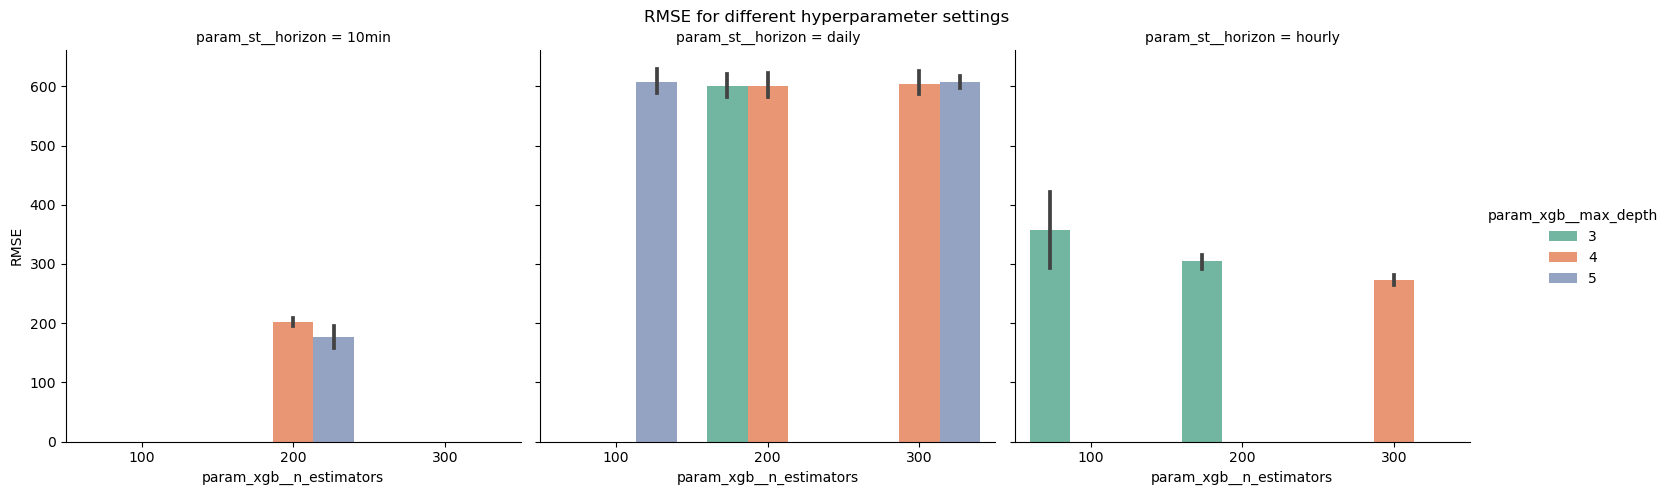

In [5]:
vis.plot_gridsearch_results(
    res_gs_brit,
    x="param_xgb__n_estimators",
    hue="param_xgb__max_depth",
)

__Analysis:__

We observe a trend toward more complex models, i.e. those with increased max_depth and a greater number of estimators. To make more certain statements, a comprehensive grid search using improved hardware resources would be necessary. The RMSE value for the  models is similar to what we have seen for other models.

In [6]:
### extract best parameters of each model for each horizon
best_params_brit_xgb = (
    res_gs_brit.set_index(["params"])[["mean_test_score", "param_st__horizon"]]
    .groupby("param_st__horizon")
    .idxmax()
)

# print best parameters for each horizon
for horizon in best_params_brit_xgb.index:
    print(
        f"Best parameters for horizon {horizon}: {ast.literal_eval(best_params_brit_xgb.loc[horizon][0])}"
    )

Best parameters for horizon 10min: {'xgb__n_estimators': 200, 'xgb__min_child_weight': 3, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1, 'st__window_size': 8, 'st__horizon': '10min'}
Best parameters for horizon daily: {'xgb__n_estimators': 300, 'xgb__min_child_weight': 2, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.01, 'st__window_size': 8, 'st__horizon': 'daily'}
Best parameters for horizon hourly: {'xgb__n_estimators': 100, 'xgb__min_child_weight': 1, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.2, 'st__window_size': 8, 'st__horizon': 'hourly'}


In [7]:
### plot predictions for best models
# refit models
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    new_model = model.set_params(
        **ast.literal_eval(best_params_brit_xgb.loc[horizon][0])
    )
    new_model.fit(X_train, y_train)
    predictions[horizon] = new_model.predict(X_test)
predictions = pd.DataFrame(predictions, index=X_test.index)

[14:14:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


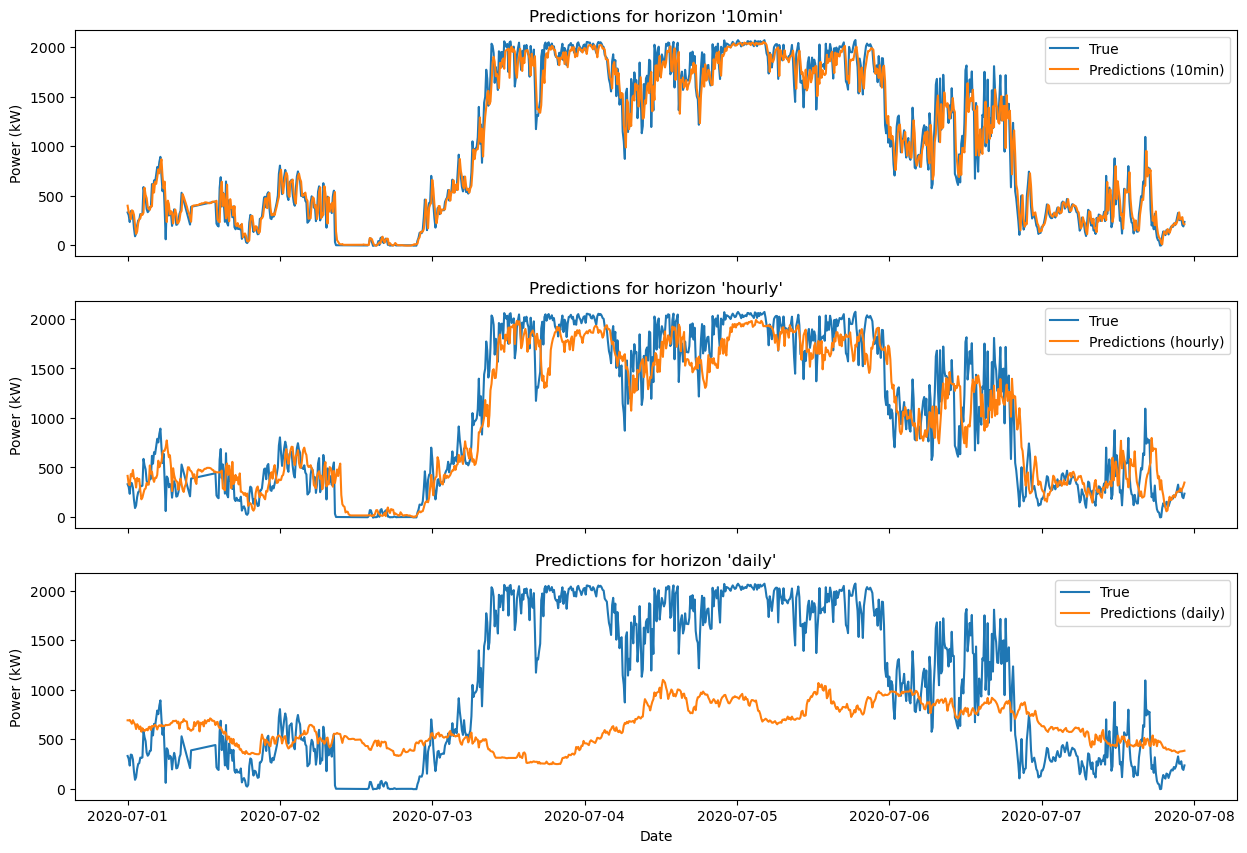

In [8]:
### plot first 100 predictions
vis.plot_predictions(predictions[:1000], y_test[:1000])

__Analysis:__

The outcomes of step-by-step and hourly forecasting produce good results, very similar to the other models examined. When it comes to daily forecasting, the predictions appear to be even more conservative than the one the regression models provided and resemble an average representation of the underlying ground truth, meaning that not every peak is faithfully mirrored in the forecasted curve. 

## Brazilian Dataset - Beberine

In [9]:
### loading data
TURBINE_ID = 1
data_braz = load_data(turbine_id=TURBINE_ID, which_data="Brazilian")

### cleaning data 
cleaner = DataCleaner(
    features=[
        "active_power_total",
        "wind_speed",
        "wind_direction",
        "rotor_rpm",
    ],
    rename_features=[
        "power",
        "wind_speed",
        "wind_direction",
        "rotor_speed",
    ],
)
data_braz = cleaner.transform(data_braz)

# create train and test set (exactly as used in the benchmarks)
test_start = benchmarks["test_start"][3]
test_end = benchmarks["test_end"][3]
X_train, y_train, X_test, y_test = train_test_split(
    df=data_braz, test_start=test_start, test_end=test_end, target_var="power"
)

In [10]:
### hyperparameter tuning
### RUNTIME: ~ 4 min on my machine
do_gridsearch = False

if do_gridsearch:
    grid_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=TimeSeriesSplit(n_splits=3),
        verbose=2,
        n_jobs=-1,
        n_iter=15, 
        refit=False,
    )
    grid_search.fit(X_train, y_train)
    res_gs_braz = pd.DataFrame(grid_search.cv_results_)
    ### store results in csv-file
    pd.DataFrame(res_gs_braz).to_csv("../results/results_gs_xgb_braz.csv")
    # reload sometimes necessary for data type reasons
    res_gs_braz = pd.read_csv("../results/results_gs_xgb_braz.csv")
else:
    res_gs_braz = pd.read_csv("../results/results_gs_xgb_braz.csv")

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


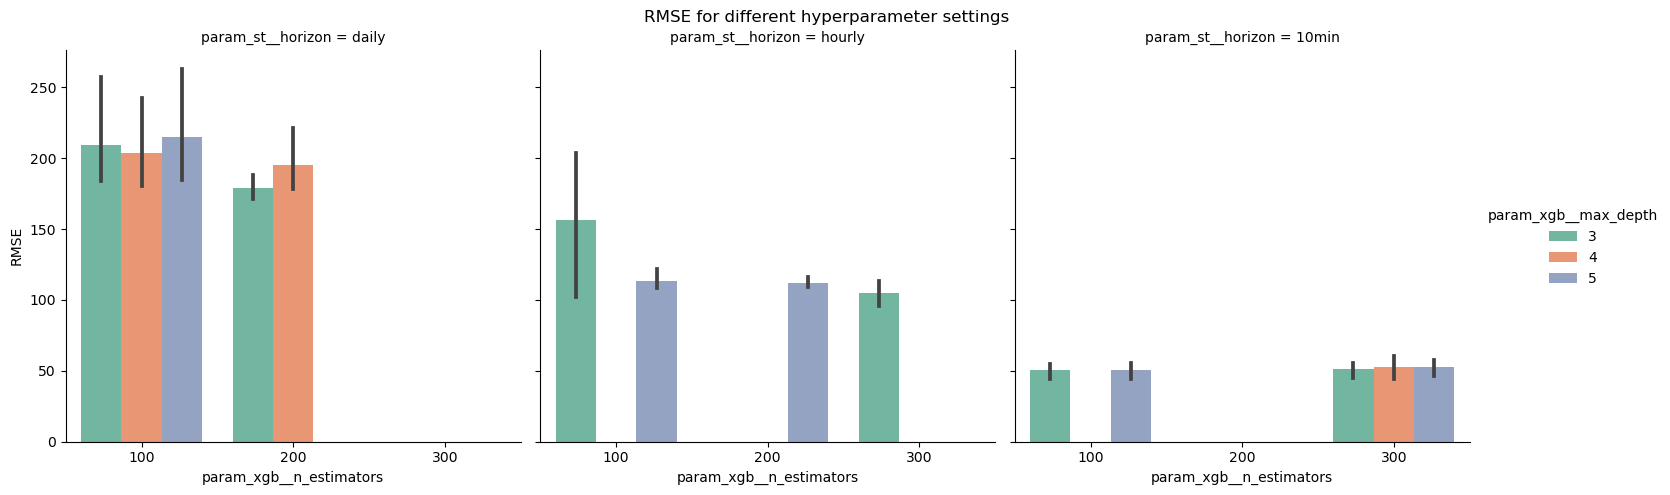

In [11]:
vis.plot_gridsearch_results(
    res_gs_braz,
    x="param_xgb__n_estimators",
    hue="param_xgb__max_depth",
)

__Analysis:__


We cannot confirm the trend towards employing more complex models for the Brazilian dataset. This could be attributed to either the dataset's size or its pronounced periodicity, suggesting that simpler models may be adequate for capturing essential patterns within the data.
 The RMSE value for the  models is similar to what we have seen for other models.

In [12]:
### extract best parameters of each model for each horizon
best_params_braz_xgb = (
    res_gs_braz.set_index(["params"])[["mean_test_score", "param_st__horizon"]]
    .groupby("param_st__horizon")
    .idxmax()
)

# print best parameters for each horizon
for horizon in best_params_braz_xgb.index:
    print(
        f"Best parameters for horizon {horizon}: {ast.literal_eval(best_params_braz_xgb.loc[horizon][0])}"
    )

Best parameters for horizon 10min: {'xgb__n_estimators': 100, 'xgb__min_child_weight': 3, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1, 'st__window_size': 8, 'st__horizon': '10min'}
Best parameters for horizon daily: {'xgb__n_estimators': 200, 'xgb__min_child_weight': 2, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'st__window_size': 8, 'st__horizon': 'daily'}
Best parameters for horizon hourly: {'xgb__n_estimators': 300, 'xgb__min_child_weight': 1, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'st__window_size': 8, 'st__horizon': 'hourly'}


In [13]:
### plot predictions for best models
# refit models
## for some reason this crashes my kernel, so I commented it out
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    new_model = model.set_params(
        **ast.literal_eval(best_params_braz_xgb.loc[horizon][0])
    )
    new_model.fit(X_train, y_train)
    predictions[horizon] = new_model.predict(X_test)
predictions = pd.DataFrame(predictions, index=X_test.index)

[14:25:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


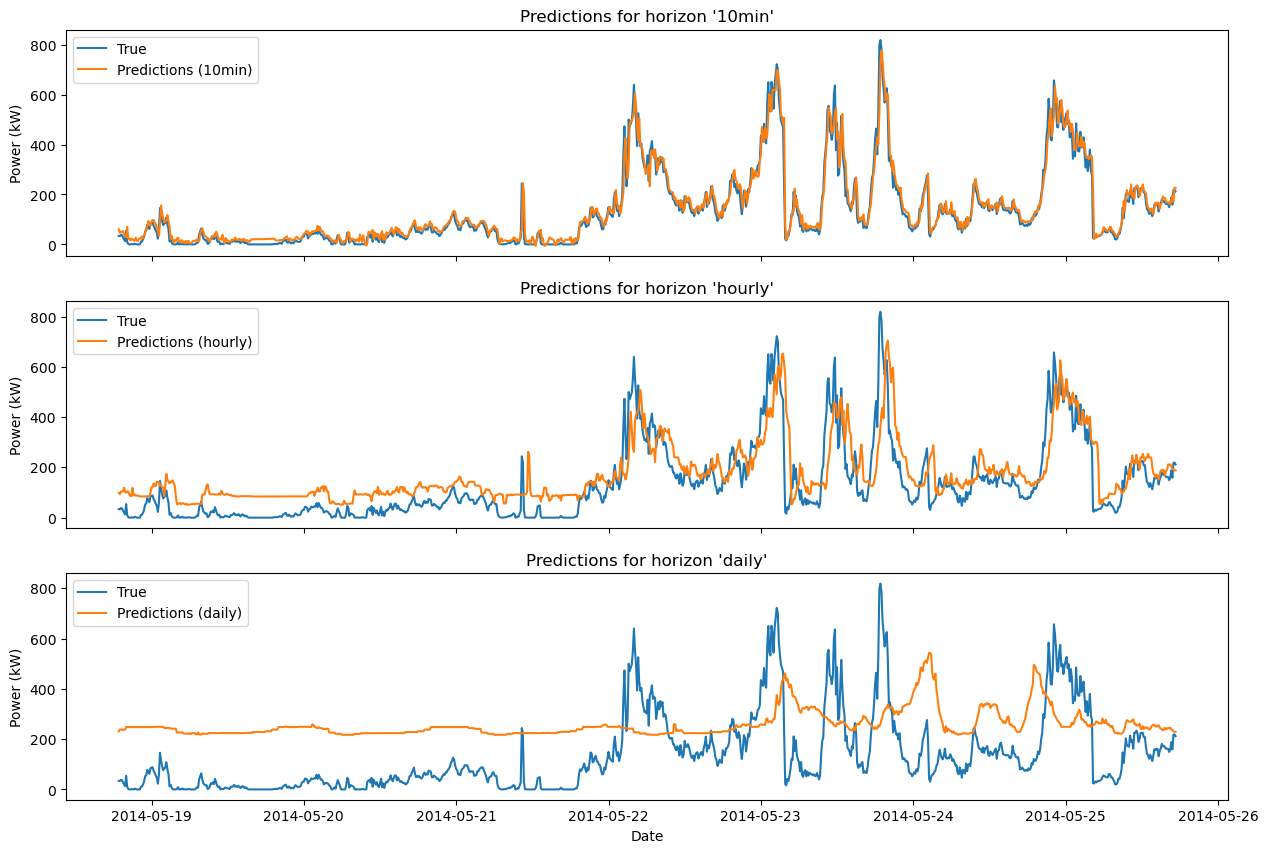

In [14]:
### plot first 1000 predictions
vis.plot_predictions(predictions[:1000], y_test[:1000])

__Analysis:__

We see similar results to the ones from the British dataset. 
Step and hourly forecasting provide good fits. Daily forecasting comes along with an average-like representation of the ground truth.

## Transfer Learning Challenge

For the transfer learning challenge we pursue the same steps as in the respective section in `RegressionVariants.ipynb`. Since we could not find a consistent pattern how to choose the hyperparameters, we use the default ones.

In [15]:
model = Pipeline(
    [
        ("fs", FeatureSelector(features=["power", "wind_speed", "wind_direction", "rotor_speed"])),
        ("st", SupervisedTransformer(encode_time=["hour", "month"])),
        ("xgb", XGB()),
    ]
)

In [16]:
norm_brit = Normalizer()
norm_brit.fit(data_brit)
norm_braz = Normalizer()
norm_braz.fit(data_braz)

Normalizer()

[14:26:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


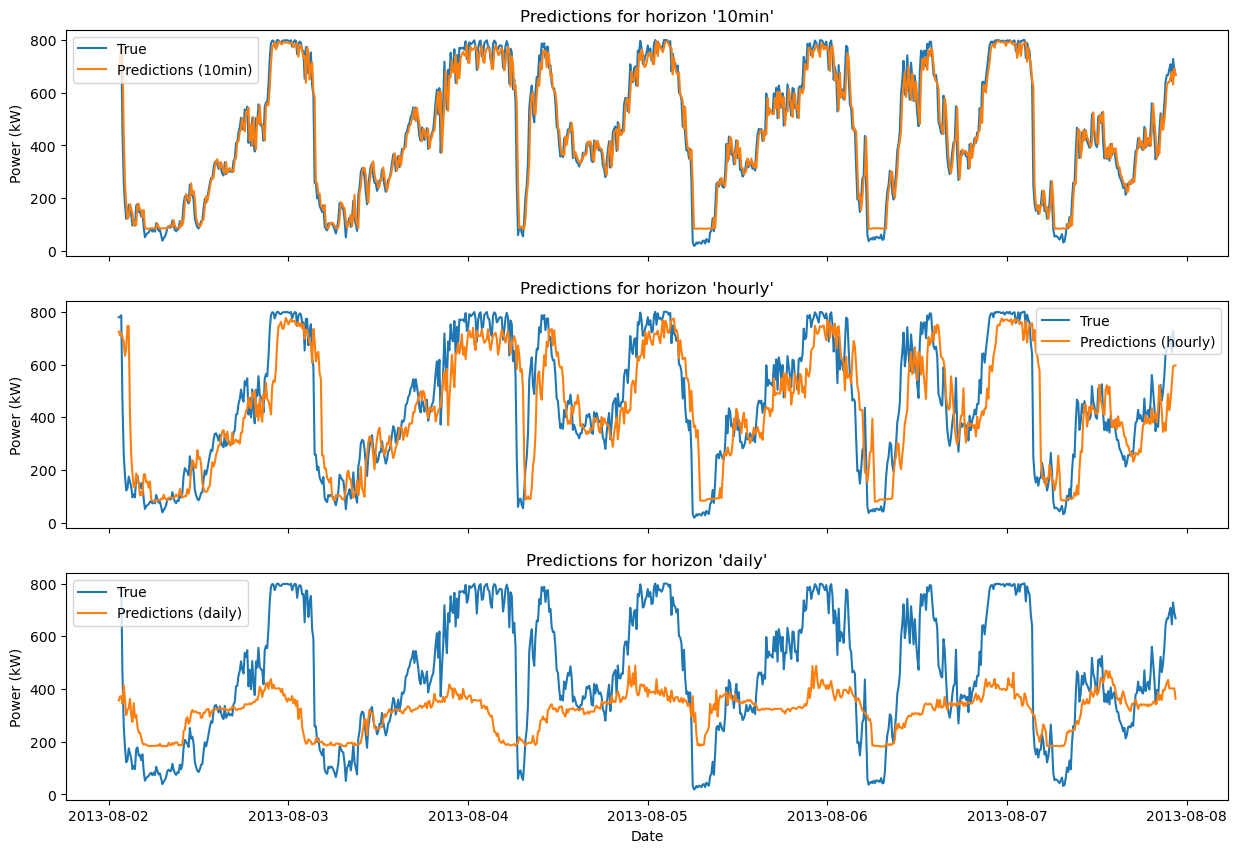

RMSE for horizon 10min: 60.63151369706436
MAE for horizon 10min: 42.280999269421145
RMSE for horizon hourly: 118.40854546796679
MAE for horizon hourly: 82.5805259596259
RMSE for horizon daily: 200.00407083196302
MAE for horizon daily: 164.8931272119339


In [17]:
### predicting brazilian from british data
X_train = norm_brit.transform(data_brit)
y_train = X_train["power"]
X_test = norm_braz.transform(data_braz)
y_test = data_braz["power"]

predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    model.set_params(**{"st__horizon": horizon})
    model.fit(X_train, y_train)
    y_pred = (model.predict(X_test) * norm_braz.scale_[0]) + norm_braz.mean_[0]
    predictions[horizon] = y_pred

predictions = pd.DataFrame(predictions, index=X_test.index)
# plotting
vis.plot_predictions(
    predictions.iloc[152:1000],
    y_test.iloc[152:1000],
)

# print errors
for horizon in predictions.columns:
    print(f"RMSE for horizon {horizon}: {mean_squared_error(y_test[152:], predictions[horizon][152:], squared=False)}")
    print(f"MAE for horizon {horizon}: {mean_absolute_error(y_test[152:], predictions[horizon][152:])}")

[14:27:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


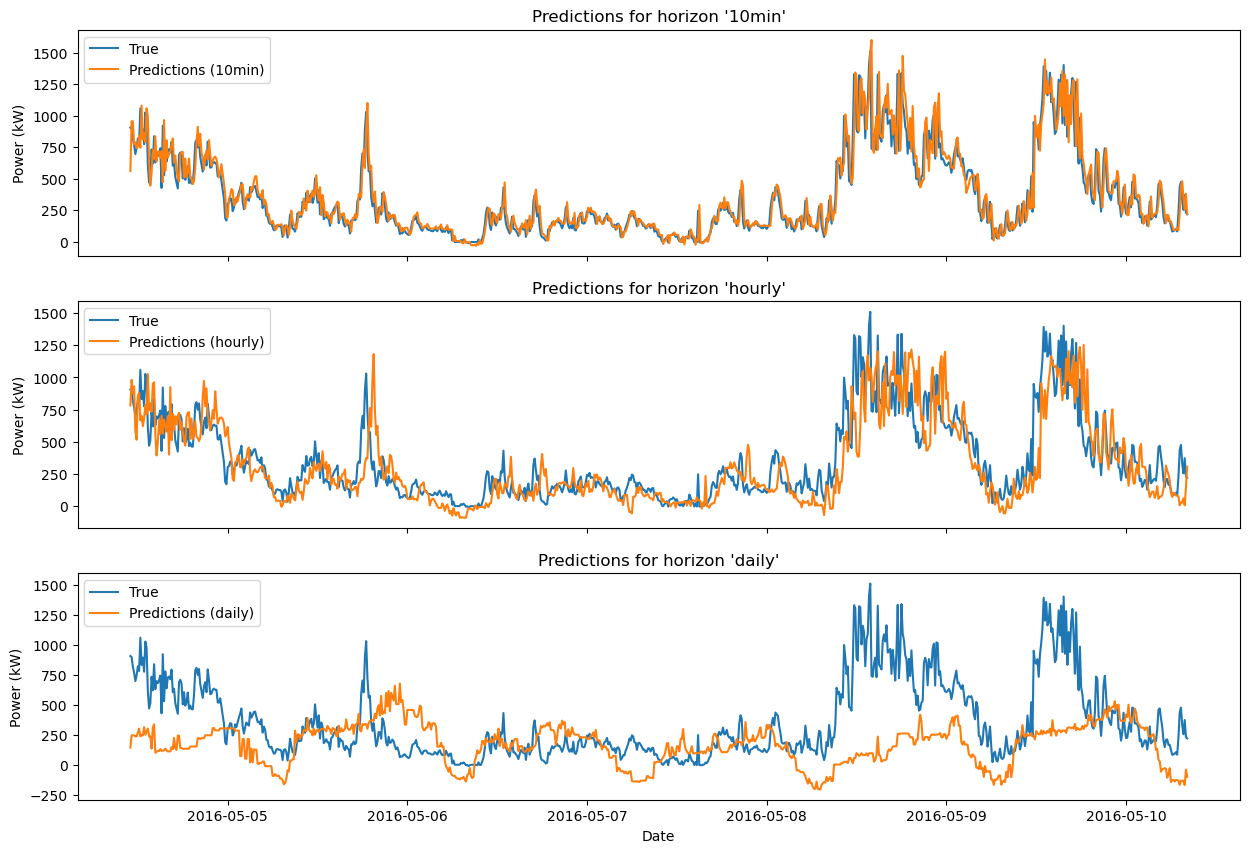

RMSE for horizon 10min: 168.45246963482327
MAE for horizon 10min: 112.7271326732437
RMSE for horizon hourly: 355.60541691463925
MAE for horizon hourly: 255.060055615927
RMSE for horizon daily: 672.2253923035755
MAE for horizon daily: 533.4890957558736


In [18]:
### predicting british from brazilian data
X_train = norm_braz.transform(data_braz)
y_train = X_train["power"]
X_test = norm_brit.transform(data_brit)
y_test = data_brit["power"]

predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    model.set_params(**{"st__horizon": horizon})
    model.fit(X_train, y_train)
    y_pred = (model.predict(X_test) * norm_brit.scale_[0]) + norm_brit.mean_[0]
    predictions[horizon] = y_pred

predictions = pd.DataFrame(predictions, index=X_test.index)
# plotting
vis.plot_predictions(
    predictions.iloc[152:1000],
    y_test.iloc[152:1000],
)

# print errors
for horizon in predictions.columns:
    print(f"RMSE for horizon {horizon}: {mean_squared_error(y_test[152:], predictions[horizon][152:], squared=False)}")
    print(f"MAE for horizon {horizon}: {mean_absolute_error(y_test[152:], predictions[horizon][152:])}")


__Summary:__

The results (RMSE Values and visual appearance of the prediction curve) of the transfer learning challenge are very similar to the ones from the regression models. An exception is for the daily forecasting of the British dataset, you can see that the model expects the same periodicity as present in the Brazilian dataset. 
Concluding from the British dataset to the Brazilian dataset seems therefore be more effective.